<a href="https://colab.research.google.com/github/JayTiptown/Urban-Audio-Classification-CNN/blob/main/sound_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soundata

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import librosa
import soundata
from tqdm import tqdm
import shutil
import requests
from pathlib import Path
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import traceback
import time
import traceback
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

In [ ]:
def process_clip(clip_id, dataset):
    try:
        clip = dataset.clip(clip_id)
        return (clip.audio_path, clip.class_id)
    except Exception as e:
        print(f"Error processing clip {clip_id}: {e}")
        return None

def prepare_urbansound8k():
    try:
        # Dataset Init and download (necessary before any training is conducted)
        dataset = soundata.initialize('urbansound8k')
        print("Downloading dataset index...")
        dataset.download()

        # Retrieve labelled clip IDs
        clip_ids = dataset.clip_ids
        print(f"Found {len(clip_ids)} clips")

        # Workers for parallel dataset processing
        num_workers = min(multiprocessing.cpu_count(), 8)
        print(f"Using {num_workers} workers for parallel processing")

        file_paths = []
        labels = []

        # Processes clips in parallel
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = [executor.submit(process_clip, clip_id, dataset)
                      for clip_id in clip_ids]

            for future in tqdm(futures, total=len(clip_ids), desc="Loading clips"):
                result = future.result()
                if result is not None:
                    file_path, label = result
                    file_paths.append(file_path)
                    labels.append(label)

        print(f"Successfully processed {len(file_paths)} clips")
        return file_paths, labels

    except Exception as e:
        print(f"Error in prepare_urbansound8k: {e}")
        traceback.print_exc()
        raise

In [ ]:
class AudioProcessor():
    def __init__(self, sr=22050, duration=4, n_mels=128):
        self.sr = sr
        self.duration = duration
        self.n_mels = n_mels
        self.n_samples = sr * duration

    def load_audio(self, file_path):
        audio, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
        if len(audio) < self.n_samples:
            audio = np.pad(audio, (0, self.n_samples - len(audio)))
        return audio[:self.n_samples]

    # mel spectrogram for interpretable data inputting
    def get_melspectrogram(self, audio):
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sr,
            n_mels=self.n_mels,
            n_fft=2048,
            hop_length=512
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db

In [ ]:
# Processes dataset

class SoundDataset(Dataset):
    def __init__(self, file_paths, labels, processor):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        audio = self.processor.load_audio(self.file_paths[idx])
        mel_spec = self.processor.get_melspectrogram(audio)
        return torch.FloatTensor(mel_spec), torch.tensor(self.labels[idx])

In [ ]:
# Convolutional Layer Processing

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(21504, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):

        x = x.unsqueeze(1)
        x = self.conv1(x)

        x = self.conv2(x)
        x = self.conv3(x)

        x = self.flatten(x)

        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_acc = 0
    metrics_log = {
        'epochs': [],
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'class_metrics': [],
        'final_predictions': None,
        'final_labels': None
    }

    class_names = ['air_conditioner', 'car_horn', 'children_playing',
                   'dog_bark', 'drilling', 'engine_idling',
                   'gun_shot', 'jackhammer', 'siren', 'street_music']

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            specs, labels = specs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(specs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for specs, labels in val_loader:
                specs, labels = specs.to(device), labels.to(device)
                outputs = model(specs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()


                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100. * val_correct / val_total
        train_acc = 100. * correct / total

        # Store final epoch predictions (for post-training analytics)
        metrics_log['final_predictions'] = all_preds
        metrics_log['final_labels'] = all_labels

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.3f}')
        print(f'Train Acc: {train_acc:.2f}%')
        print(f'Val Acc: {val_acc:.2f}%')

        if (epoch + 1) % 5 == 0:
            report = classification_report(all_labels, all_preds,
                                        target_names=class_names,
                                        output_dict=True)

            metrics_log['epochs'].append(epoch + 1)
            metrics_log['train_loss'].append(train_loss/len(train_loader))
            metrics_log['train_acc'].append(train_acc)
            metrics_log['val_acc'].append(val_acc)
            metrics_log['class_metrics'].append(report)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'metrics_log': metrics_log
            }, 'best_model.pth')

    return metrics_log

In [ ]:
# Test cell to ensure data is loading properly from UrbanSound8K

def test_data_loading():
    try:
        print("Starting parallel data loading test...")
        start_time = time.time()
        file_paths, labels = prepare_urbansound8k()
        end_time = time.time()
        if file_paths and labels:
            print("\nData Loading Results:")
            print(f"Total samples loaded: {len(file_paths)}")
            print(f"First file path: {file_paths[0]}")
            print(f"First label: {labels[0]}")
            print(f"\nLoading time: {end_time - start_time:.2f} seconds")

            class_counts = Counter(labels)
            print("\nClass distribution:")
            for class_id, count in sorted(class_counts.items()):
                print(f"Class {class_id}: {count} samples")

    except Exception as e:
        print(f"Error in test_data_loading: {e}")
        traceback.print_exc()

# uncomment to test data loading
# if __name__ == "__main__":
    # test_data_loading()

In [ ]:
# Visualization function for post-training analytics

def visualize_training_results(metrics_log):

    if not metrics_log['epochs']:
        print("No metrics were collected. Check num_epochs in execution cell")
        return

    plt.figure(figsize=(15, 5))

    # Training and Validation accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics_log['epochs'], metrics_log['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(metrics_log['epochs'], metrics_log['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Model Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics_log['epochs'], metrics_log['train_loss'], 'go-', label='Training Loss')
    plt.title('Model Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if metrics_log['final_predictions'] is None or metrics_log['final_labels'] is None:
        print("No final predictions available")
        return

    # class list from dataset
    class_names = ['air_conditioner', 'car_horn', 'children_playing',
                   'dog_bark', 'drilling', 'engine_idling',
                   'gun_shot', 'jackhammer', 'siren', 'street_music']


    # Confusion Matrix Plotting
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(metrics_log['final_labels'], metrics_log['final_predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    if metrics_log['class_metrics']:
        final_metrics = metrics_log['class_metrics'][-1]

        # Bar plot of class performance
        metrics_data = []
        for class_name in class_names:
            if class_name in final_metrics:
                metrics_data.append([
                    final_metrics[class_name]['precision'],
                    final_metrics[class_name]['recall'],
                    final_metrics[class_name]['f1-score']
                ])
            else:
                metrics_data.append([0, 0, 0])

        metrics_data = np.array(metrics_data)
        plt.figure(figsize=(15, 6))
        x = np.arange(len(class_names))
        width = 0.25

        plt.bar(x - width, metrics_data[:, 0], width, label='Precision')
        plt.bar(x, metrics_data[:, 1], width, label='Recall')
        plt.bar(x + width, metrics_data[:, 2], width, label='F1-Score')
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Per-Class Performance Metrics')
        plt.xticks(x, class_names, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No class metrics available")

Using device: cuda
Loading dataset...
Found 8732 clips
Using 8 workers for parallel processing


Loading clips: 100%|██████████| 8732/8732 [00:00<00:00, 501535.95it/s]


Successfully processed 8732 clips
Training samples: 6985
Validation samples: 1747
Using 8 workers for data loading
Starting training...


Epoch 1/30: 100%|██████████| 219/219 [02:30<00:00,  1.46it/s]


Epoch 1/30:
Train Loss: 2.285
Train Acc: 37.37%
Val Acc: 48.94%


Epoch 2/30: 100%|██████████| 219/219 [02:27<00:00,  1.49it/s]


Epoch 2/30:
Train Loss: 1.374
Train Acc: 49.65%
Val Acc: 61.08%


Epoch 3/30: 100%|██████████| 219/219 [02:23<00:00,  1.52it/s]


Epoch 3/30:
Train Loss: 1.221
Train Acc: 55.66%
Val Acc: 66.11%


Epoch 4/30: 100%|██████████| 219/219 [02:22<00:00,  1.53it/s]


Epoch 4/30:
Train Loss: 1.052
Train Acc: 61.69%
Val Acc: 69.49%


Epoch 5/30: 100%|██████████| 219/219 [02:23<00:00,  1.53it/s]


Epoch 5/30:
Train Loss: 0.958
Train Acc: 65.21%
Val Acc: 75.56%


Epoch 6/30: 100%|██████████| 219/219 [02:27<00:00,  1.49it/s]


Epoch 6/30:
Train Loss: 0.834
Train Acc: 70.12%
Val Acc: 74.36%


Epoch 7/30: 100%|██████████| 219/219 [02:27<00:00,  1.49it/s]


Epoch 7/30:
Train Loss: 0.739
Train Acc: 73.19%
Val Acc: 81.28%


Epoch 8/30: 100%|██████████| 219/219 [02:23<00:00,  1.52it/s]


Epoch 8/30:
Train Loss: 0.649
Train Acc: 77.12%
Val Acc: 81.00%


Epoch 9/30: 100%|██████████| 219/219 [02:27<00:00,  1.48it/s]


Epoch 9/30:
Train Loss: 0.605
Train Acc: 78.34%
Val Acc: 83.29%


Epoch 10/30: 100%|██████████| 219/219 [02:26<00:00,  1.50it/s]


Epoch 10/30:
Train Loss: 0.548
Train Acc: 80.26%
Val Acc: 82.88%


Epoch 11/30: 100%|██████████| 219/219 [02:24<00:00,  1.52it/s]


Epoch 11/30:
Train Loss: 0.463
Train Acc: 83.49%
Val Acc: 83.57%


Epoch 12/30: 100%|██████████| 219/219 [02:24<00:00,  1.52it/s]


Epoch 12/30:
Train Loss: 0.442
Train Acc: 84.57%
Val Acc: 84.89%


Epoch 13/30: 100%|██████████| 219/219 [02:23<00:00,  1.53it/s]


Epoch 13/30:
Train Loss: 0.401
Train Acc: 86.01%
Val Acc: 87.52%


Epoch 14/30: 100%|██████████| 219/219 [02:27<00:00,  1.49it/s]


Epoch 14/30:
Train Loss: 0.363
Train Acc: 87.14%
Val Acc: 86.03%


Epoch 15/30: 100%|██████████| 219/219 [02:25<00:00,  1.51it/s]


Epoch 15/30:
Train Loss: 0.338
Train Acc: 87.80%
Val Acc: 89.47%


Epoch 16/30: 100%|██████████| 219/219 [02:24<00:00,  1.52it/s]


Epoch 16/30:
Train Loss: 0.302
Train Acc: 88.92%
Val Acc: 87.41%


Epoch 17/30: 100%|██████████| 219/219 [02:22<00:00,  1.54it/s]


Epoch 17/30:
Train Loss: 0.287
Train Acc: 89.49%
Val Acc: 89.12%


Epoch 18/30: 100%|██████████| 219/219 [02:25<00:00,  1.51it/s]


Epoch 18/30:
Train Loss: 0.258
Train Acc: 90.28%
Val Acc: 89.93%


Epoch 19/30: 100%|██████████| 219/219 [02:23<00:00,  1.52it/s]


Epoch 19/30:
Train Loss: 0.247
Train Acc: 90.92%
Val Acc: 88.44%


Epoch 20/30: 100%|██████████| 219/219 [02:20<00:00,  1.56it/s]


Epoch 20/30:
Train Loss: 0.213
Train Acc: 92.31%
Val Acc: 88.90%


Epoch 21/30: 100%|██████████| 219/219 [02:25<00:00,  1.51it/s]


Epoch 21/30:
Train Loss: 0.223
Train Acc: 92.03%
Val Acc: 90.04%


Epoch 22/30: 100%|██████████| 219/219 [02:23<00:00,  1.53it/s]


Epoch 22/30:
Train Loss: 0.214
Train Acc: 92.40%
Val Acc: 88.04%


Epoch 23/30: 100%|██████████| 219/219 [02:28<00:00,  1.47it/s]


Epoch 23/30:
Train Loss: 0.196
Train Acc: 92.84%
Val Acc: 89.58%


Epoch 24/30: 100%|██████████| 219/219 [02:30<00:00,  1.46it/s]


Epoch 24/30:
Train Loss: 0.184
Train Acc: 93.27%
Val Acc: 90.10%


Epoch 25/30: 100%|██████████| 219/219 [02:25<00:00,  1.50it/s]


Epoch 25/30:
Train Loss: 0.181
Train Acc: 93.47%
Val Acc: 90.84%


Epoch 26/30: 100%|██████████| 219/219 [02:21<00:00,  1.55it/s]


Epoch 26/30:
Train Loss: 0.169
Train Acc: 93.93%
Val Acc: 87.81%


Epoch 27/30: 100%|██████████| 219/219 [02:23<00:00,  1.53it/s]


Epoch 27/30:
Train Loss: 0.160
Train Acc: 94.76%
Val Acc: 90.73%


Epoch 28/30: 100%|██████████| 219/219 [02:21<00:00,  1.55it/s]


Epoch 28/30:
Train Loss: 0.170
Train Acc: 94.03%
Val Acc: 91.41%


Epoch 29/30: 100%|██████████| 219/219 [02:25<00:00,  1.51it/s]


Epoch 29/30:
Train Loss: 0.143
Train Acc: 94.63%
Val Acc: 90.44%


Epoch 30/30: 100%|██████████| 219/219 [02:21<00:00,  1.55it/s]


Epoch 30/30:
Train Loss: 0.134
Train Acc: 95.39%
Val Acc: 88.95%

Training complete!
Best validation accuracy: 90.84%

Generating training visualizations...


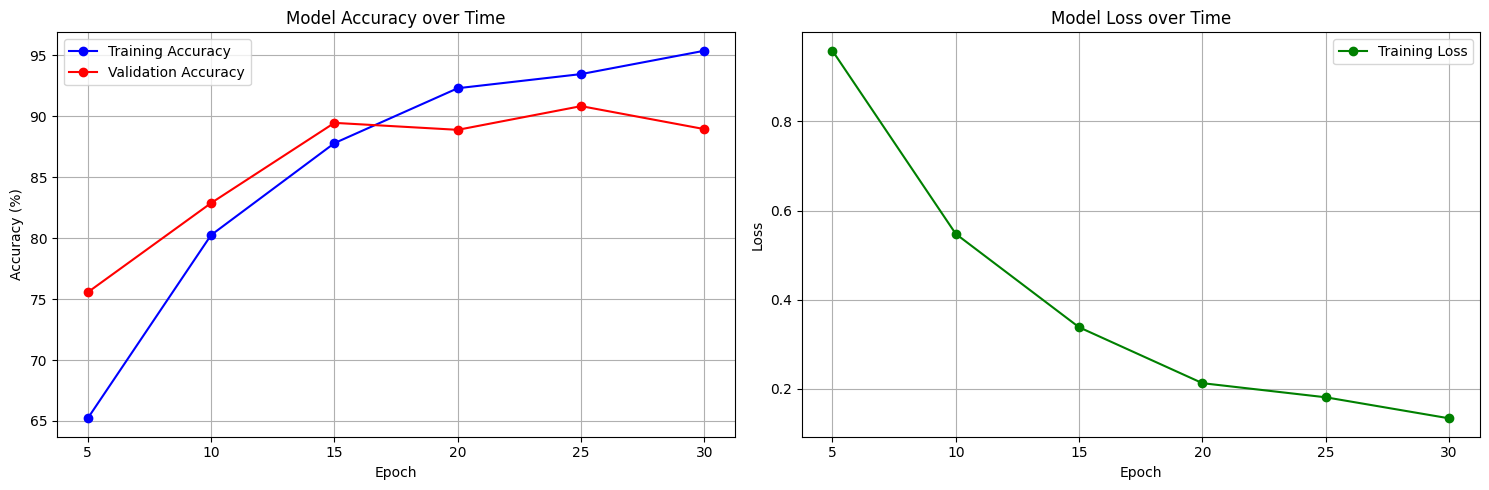

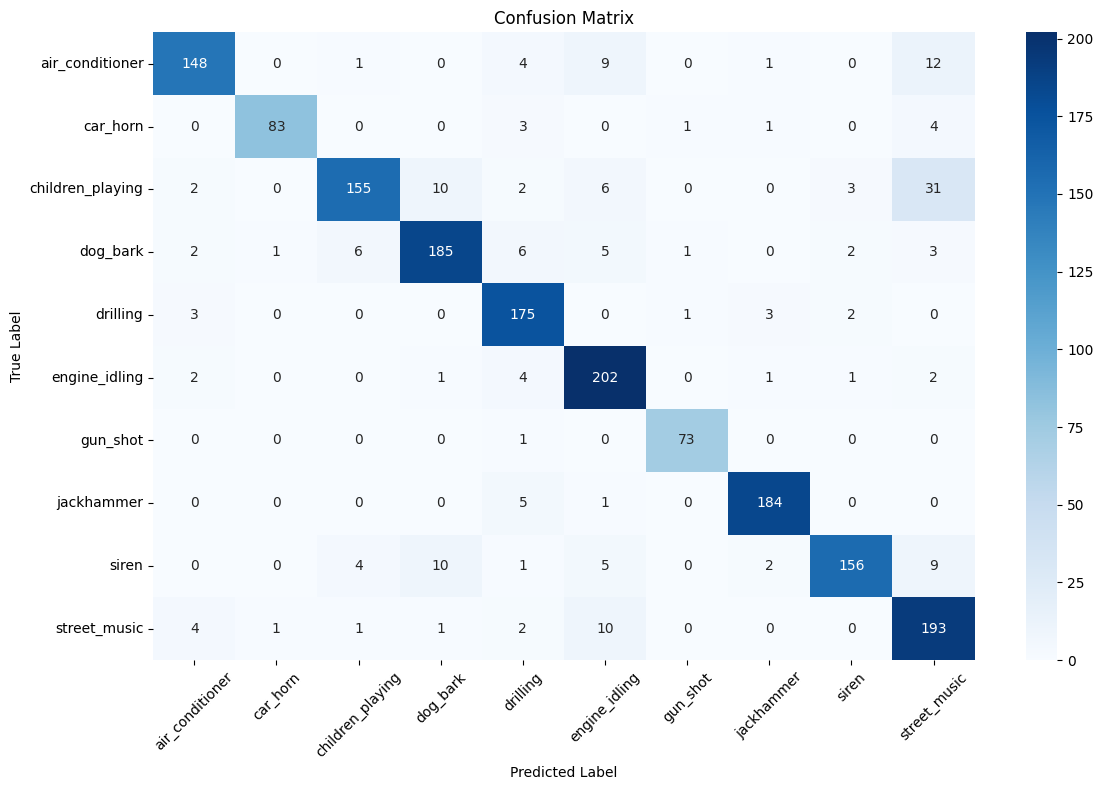

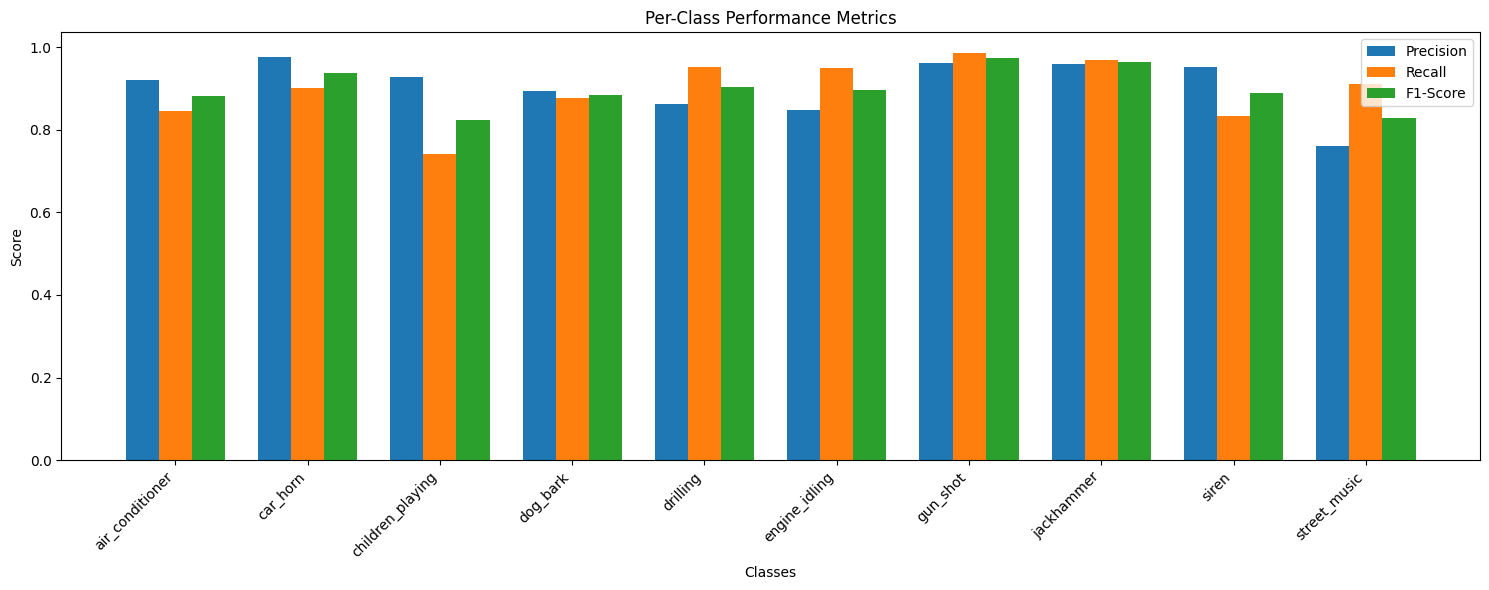

In [ ]:
def main():

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    # loads dataset
    print("Loading dataset...")
    file_paths, labels = prepare_urbansound8k()
    processor = AudioProcessor()

    # Split data
    train_files, val_files, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.2, random_state=42
    )

    print(f"Training samples: {len(train_files)}")
    print(f"Validation samples: {len(val_files)}")

    train_dataset = SoundDataset(train_files, train_labels, processor)
    val_dataset = SoundDataset(val_files, val_labels, processor)

    # optimal number of workers to optimize training time
    num_workers = min(os.cpu_count(), 8)
    print(f"Using {num_workers} workers for data loading")
    # Parallelized data loading
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )

    model = AudioCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Starting training...")
    metrics_log = train_model(model, train_loader, val_loader, criterion, optimizer,
                            num_epochs=30, device=device)
    print("\nTraining complete!")
    print(f"Best validation accuracy: {max(metrics_log['val_acc']):.2f}%")

    # visualizations displayed after training
    print("\nGenerating training visualizations...")
    visualize_training_results(metrics_log)

    # local saved metrics
    torch.save({
        'metrics_log': metrics_log
    }, 'training_metrics.pth')

if __name__ == '__main__':
    main()